In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from thalamus_merfish_analysis import abc_load as abc

In [2]:
import nibabel
import anndata as ad
import numpy as np
import pandas as pd
import scipy.ndimage as ndi

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
%matplotlib inline

## walkthrough of abc.label_thalamus_spatial_subset()

In [43]:
cells_df = abc.get_combined_metadata(drop_unused=False)

In [44]:
ccf_df = pd.read_csv(
        abc.ABC_ROOT/"metadata/Allen-CCF-2020/20230630/parcellation_to_parcellation_term_membership.csv"
        )

In [45]:
th_zi_ind = np.hstack(
        (ccf_df.loc[ccf_df['parcellation_term_acronym']=='TH', 
                    'parcellation_index'].unique(),
             ccf_df.loc[ccf_df['parcellation_term_acronym']=='ZI', 
                    'parcellation_index'].unique())
)
len(th_zi_ind)
# th_zi_ind

53

In [46]:

import nibabel
img = nibabel.load("/data/realigned/abc_realigned_ccf_labels.nii.gz")
# could maybe keep the lazy dataobj and not convert to numpy?
ccf_img = np.array(img.dataobj)

## resampled ccf (z resolution limited to merscope slices)

In [47]:
# takes about 5 sec
th_mask = np.isin(ccf_img, th_zi_ind)

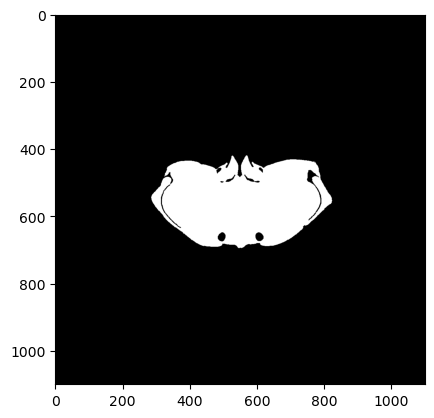

In [48]:
plt.imshow(th_mask[:,:,35].T,cmap='gray') #, extent=(0,11,0,11))

## comparison to subclasses

In [49]:
th_subclasses = ['168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut', '101 ZI Pax6 Gaba',
                  '109 LGv-ZI Otx2 Gaba', '093 RT-ZI Gnb3 Gaba',
                  '149 PVT-PT Ntrk1 Glut', '151 TH Prkcd Grin2c Glut',
                  '152 RE-Xi Nox4 Glut', '154 PF Fzd5 Glut',
                  '203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba',
                  '148 AV Col27a1 Glut', '146 LH Pou4f1 Sox1 Glut',
                  '147 AD Serpinb7 Glut', '153 MG-POL-SGN Nts Glut',
                  '110 BST-po Iigp1 Glut', '150 CM-IAD-CL-PCN Sema5b Glut',
                  '145 MH Tac2 Glut']
cells_df['thal_subclass'] = cells_df["subclass"].isin(th_subclasses)

In [50]:
cells_df.columns

Index(['brain_section_label', 'cluster_alias', 'average_correlation_score',
       'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex',
       'x_section', 'y_section', 'z_section', 'neurotransmitter', 'class',
       'subclass', 'supertype', 'cluster', 'neurotransmitter_color',
       'class_color', 'subclass_color', 'supertype_color', 'cluster_color',
       'x_reconstructed', 'y_reconstructed', 'z_reconstructed',
       'parcellation_index', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_organ',
       'parcellation_category', 'parcellation_division',
       'parcellation_structure', 'parcellation_substructure',
       'parcellation_organ_color', 'parcellation_category_color',
       'parcellation_division_color', 'parcellation_structure_color',
       'parcellation_substructure_color', 'thal_subclass'],
      dtype='object')

In [51]:
field_name='TH_ZI_dataset'
# use reconstructed (in MERFISH space) coordinates from cells_df
# coords = ['x_reconstructed','y_reconstructed','z_reconstructed']
coords = ['x_section','y_section','z_section']
res = np.array([10e-3, 10e-3, 200e-3])

In [52]:
data = dict()
for radius in [1,5,10,15,20,30,40]:
    mask = abc.sectionwise_dilation(th_mask, radius)
    abc.label_masked_cells(cells_df, mask, coords, res, field_name=field_name)
    data[radius] = (cells_df.loc[cells_df['thal_subclass']]
        .groupby(coords[2])[field_name].mean().loc[lambda x: x>0])

(0.0, 1.0)

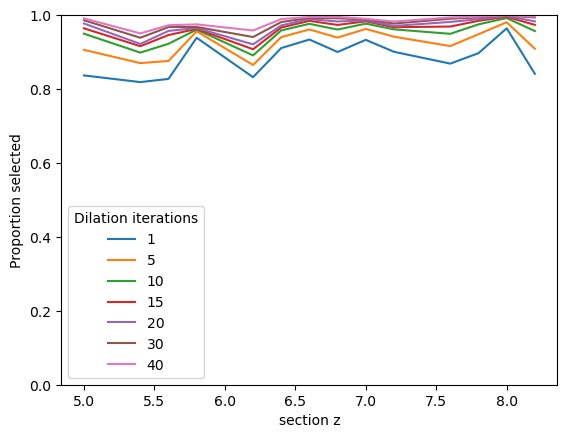

In [54]:
for i, xy in data.items():
    plt.plot(xy, label=i)

    # plt.ylim(0.2,1.1)
plt.ylabel('Proportion selected')
plt.xlabel('section z')
plt.legend(title='Dilation iterations')
plt.ylim(0,1)

At ten iterations, this seems pretty safe (end sections were already dropped when generating the realigned ccf image)


### visualize which cells are captured by the TH mask

In [55]:
def plot_th_mask_with_cell_overlay(cell_df, th_mask, th_zi_sections, 
                                   column='class'):

    # make a fixed colormap for displaying thalamus mask
    cmap_th_mask = colors.ListedColormap(['lightgrey', 'white'])
    bounds=[0,1]
    norm = colors.BoundaryNorm(bounds, cmap_th_mask.N)

    # define legend elements for the column colors
    color_col = column+'_color'
    categories = cell_df[column].unique()
    cat_color_mapping = dict(zip(categories, cell_df[color_col].unique()))
    # sort the dict & the categories list by category
    cat_color_mapping = dict(sorted(cat_color_mapping.items()))
    categories = sorted(categories)
    legend_elements = [Line2D([0], [0], 
                              lw=0, marker='o', markersize=10,
                              markerfacecolor=cat_color_mapping[cat],
                              color=cat_color_mapping[cat], 
                              label=cat) 
                       for cat in cat_color_mapping]
    
    n_col = 2
    n_row = int(np.ceil(len(th_zi_sections) / n_col))
    fig, axes = plt.subplots(n_row, n_col, figsize=(12,30))
    axes = axes.ravel()

    x_min = 2.5; x_max = 8.5; y_min = 7.5; y_max = 4

    for i, sec in enumerate(th_zi_sections):
        ax = axes[i]

        curr_sec_cell_df = cell_df[(cell_df[coords[2]]==sec)]

        ax.imshow(th_mask[:,:,int(np.rint(sec/0.2))].T, extent=[0, 11, 11, 0], zorder=0,
                  cmap=cmap_th_mask, norm=norm)
        sc = ax.scatter(curr_sec_cell_df[coords[0]], curr_sec_cell_df[coords[1]],
                        color=curr_sec_cell_df['class_color'],
                        s=0.5, marker='.', zorder=1)
        ax.set_title('z='+str(sec))

        ax.set_xlim((x_min,x_max))
        ax.set_xlabel(coords[0])
        ax.set_ylabel(coords[1])
        ax.set_ylim((y_min,y_max))
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])

        if i==7:
            ax.legend(legend_elements, categories, title='class', 
                      loc='center left', bbox_to_anchor=(1.1,0.5))

In [56]:
# th_zi_sections = sorted(th_df['z_section'].unique())
th_zi_sections = sorted(cells_df[coords[2]].unique())[19:35]
th_mask_dilated = abc.sectionwise_dilation(th_mask, 10)

In [57]:
nn_classes = ['30 Astro-Epen', '31 OPC-Oligo', '32 OEC', '33 Vascular', '34 Immune']
th_zi_classes = ['12 HY GABA', '13 CNU-HYa Glut','17 MH-LH Glut','18 TH Glut']

#### neuronal classes

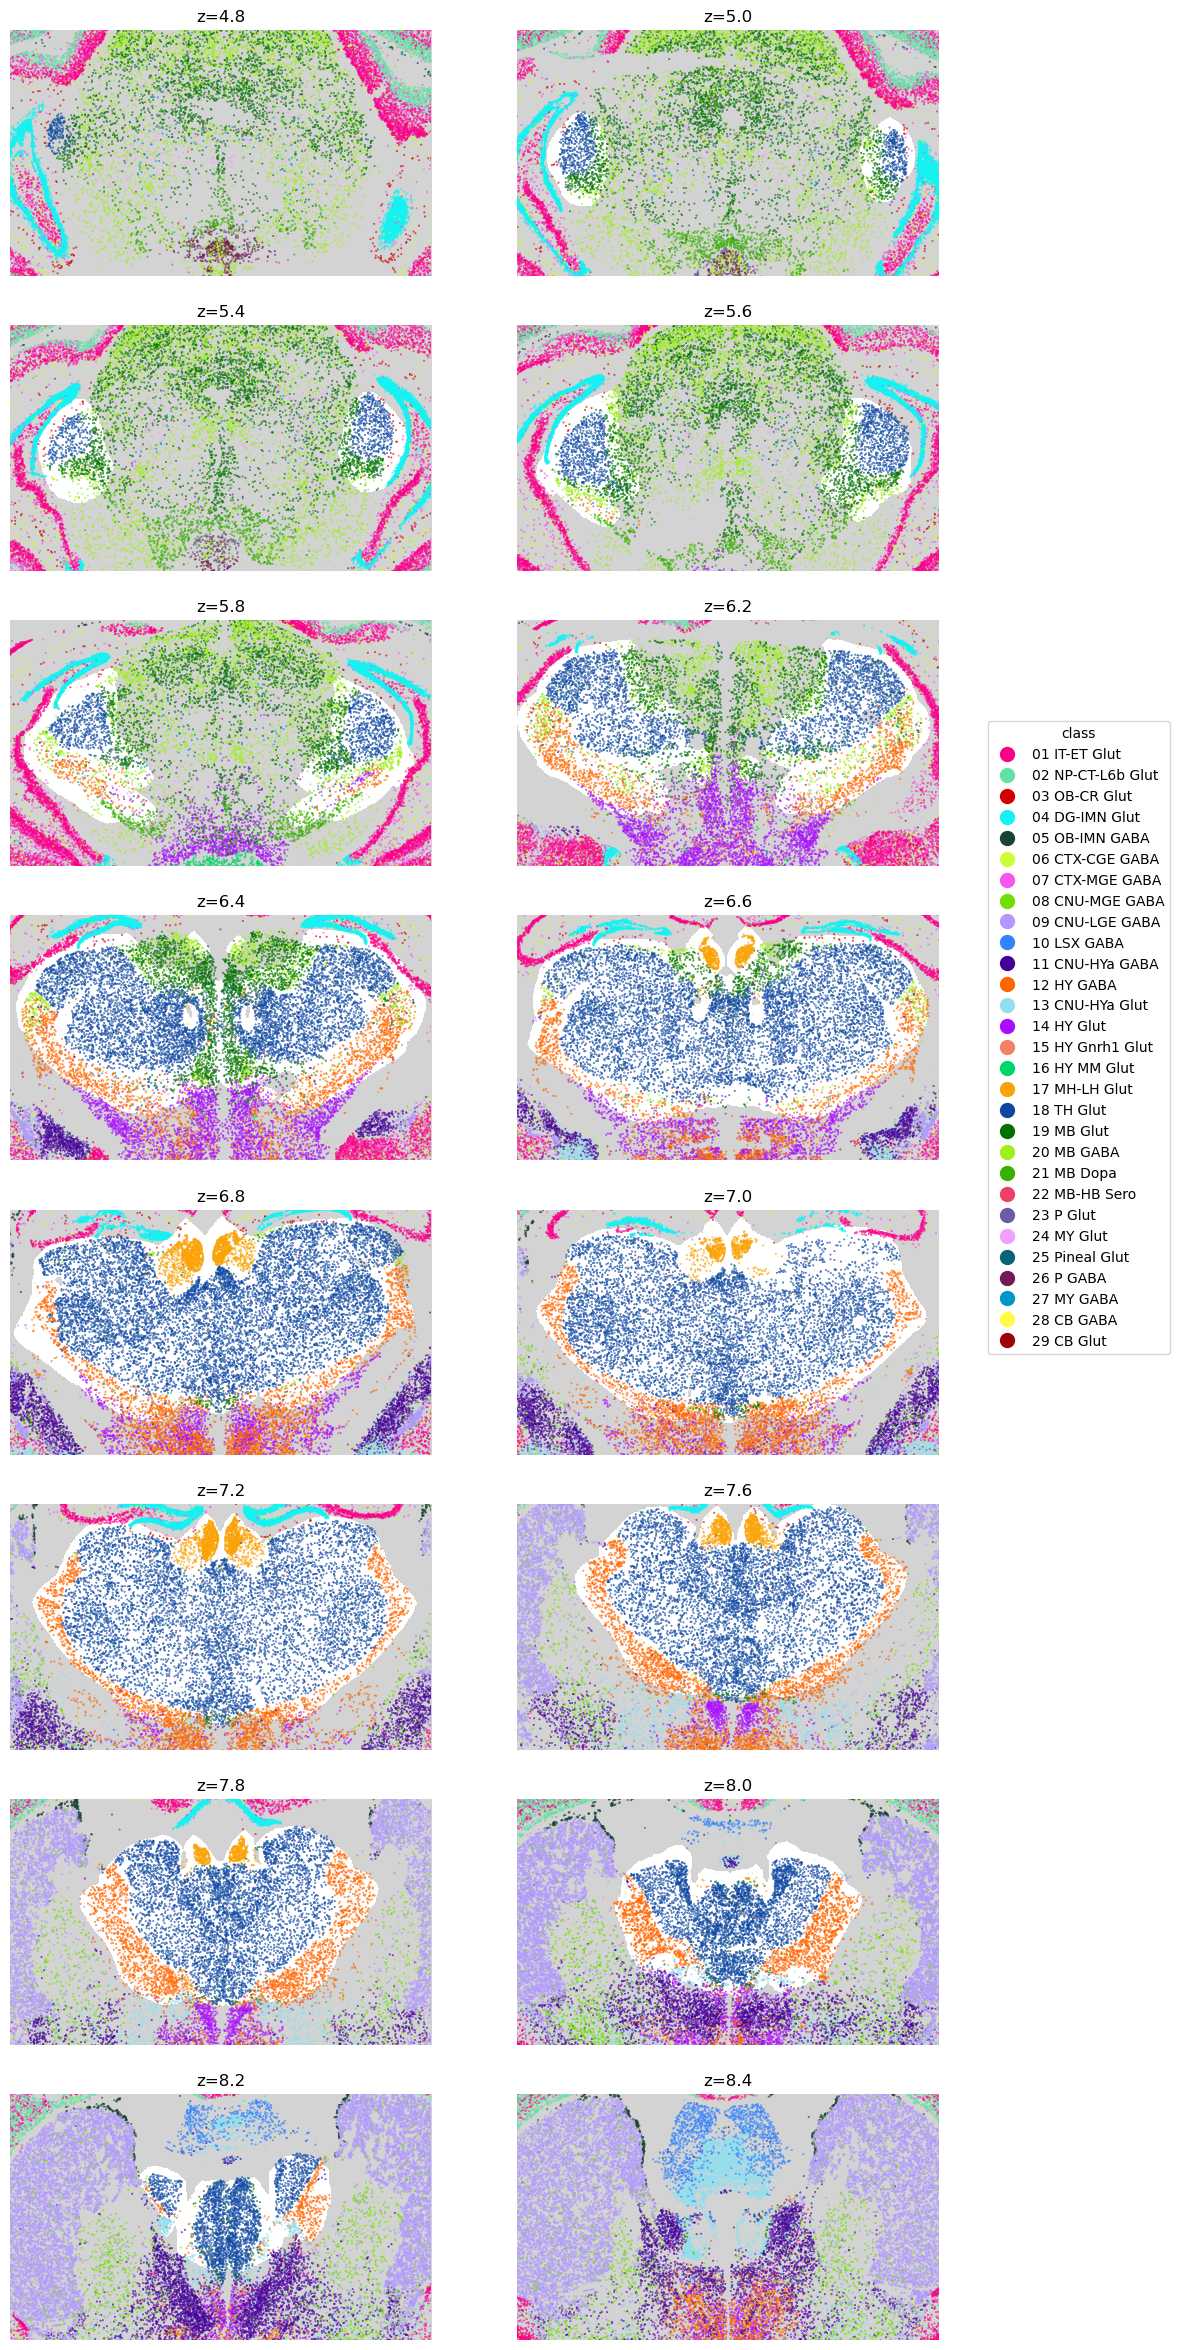

In [58]:
neuronal_cells_df = cells_df[(~cells_df['class'].isin(nn_classes))
                             & (cells_df[coords[2]].isin(th_zi_sections))
                            ]  #& (cells_df['thal_subclass'])
plot_th_mask_with_cell_overlay(neuronal_cells_df, th_mask_dilated, th_zi_sections, column='class')

#### thalamus classes only

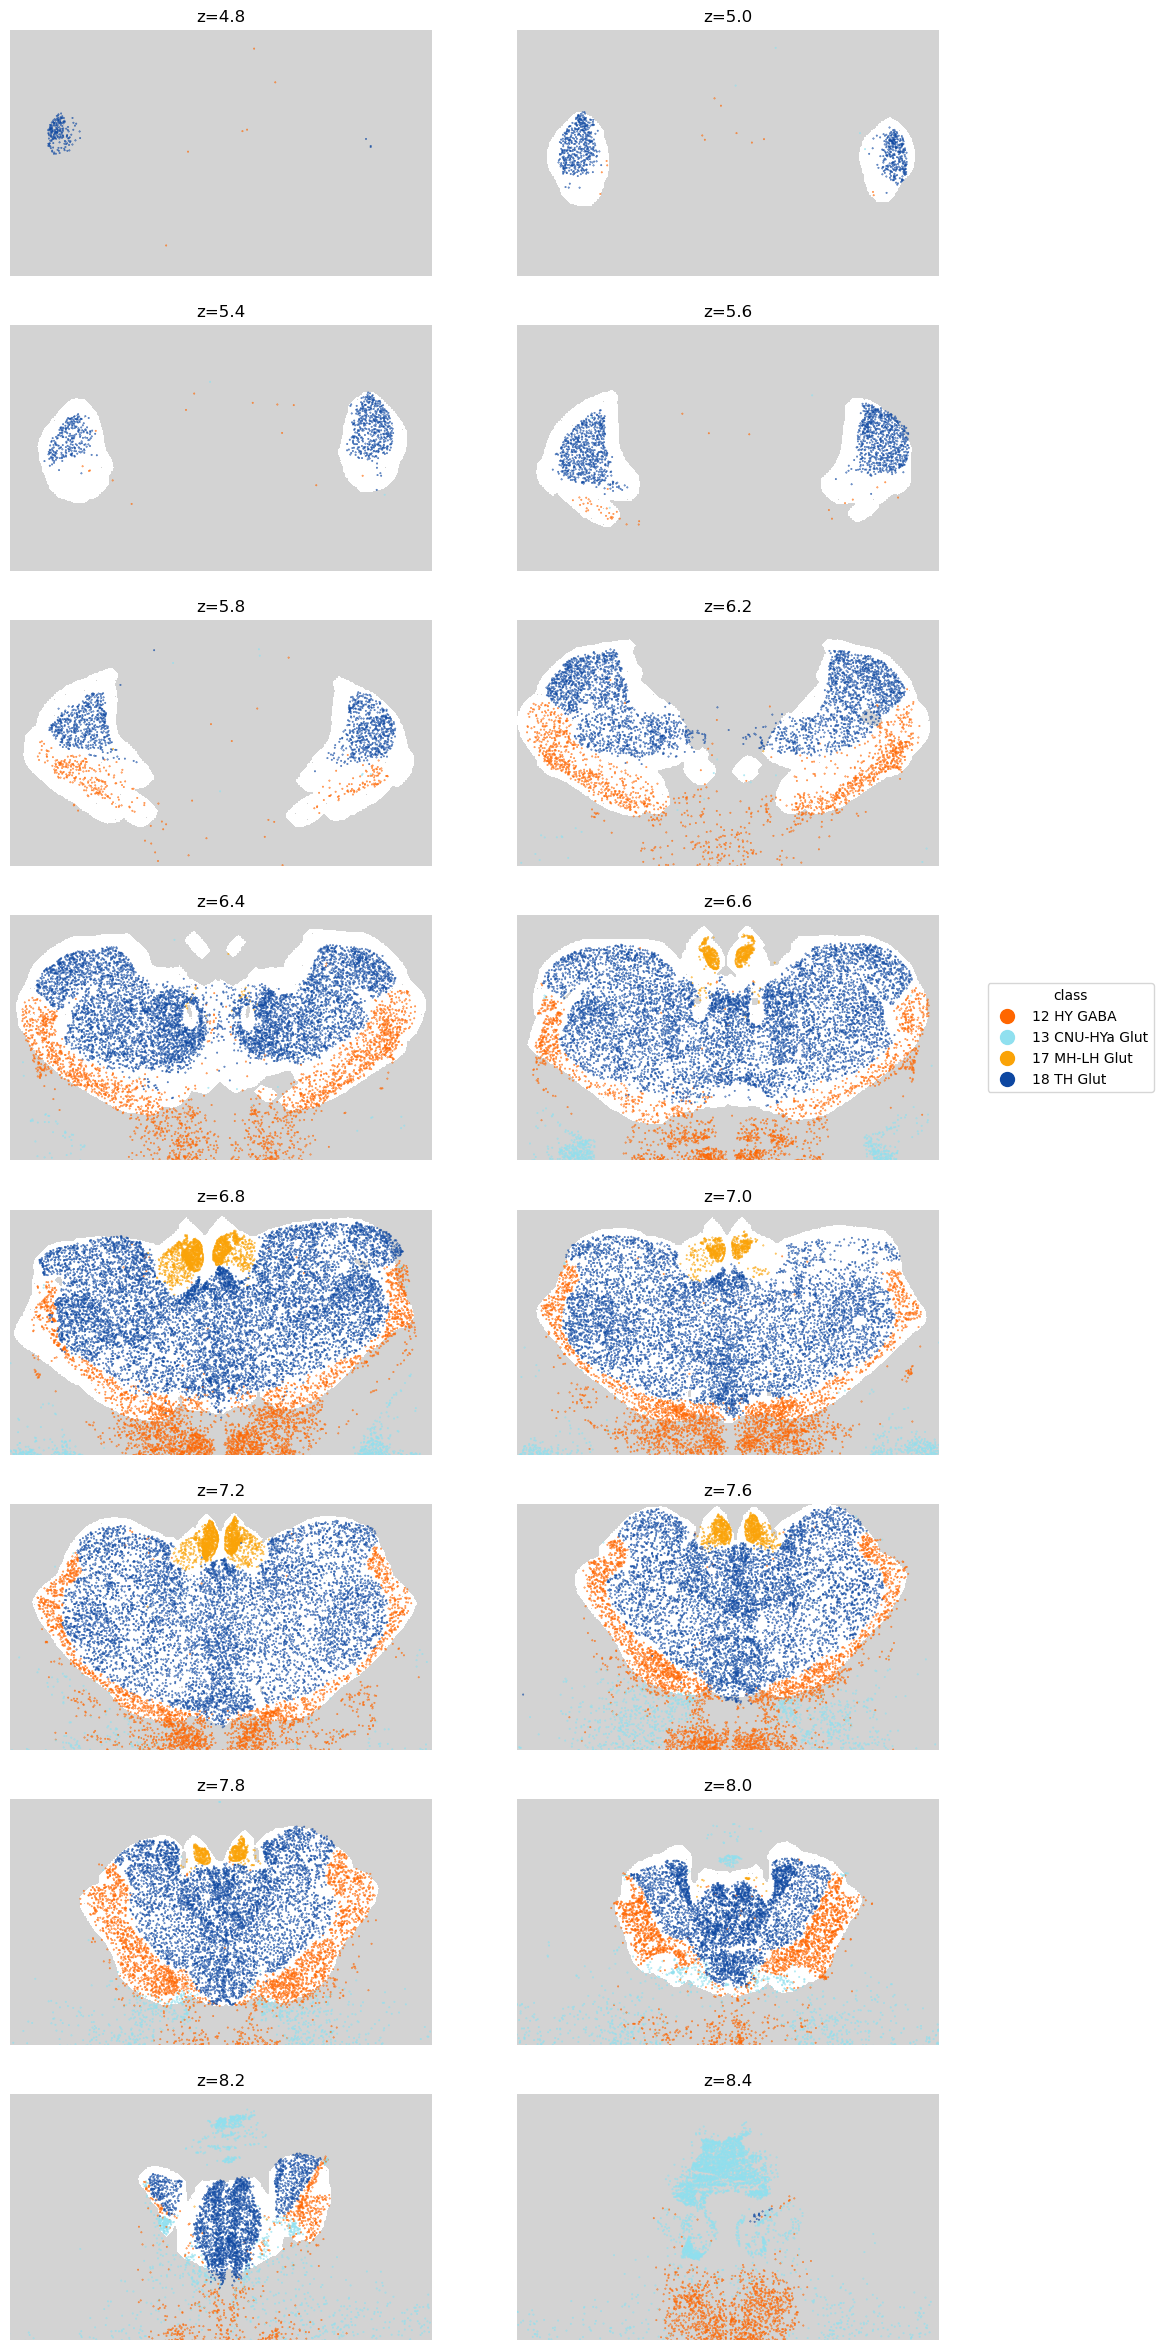

In [59]:
neuronal_th_cells_df = cells_df[(~cells_df['class'].isin(nn_classes))
                                & (cells_df[coords[2]].isin(th_zi_sections))
                                & (cells_df['class'].isin(th_zi_classes))
                               ]  
plot_th_mask_with_cell_overlay(neuronal_th_cells_df, th_mask_dilated, th_zi_sections, column='class')

#### thalamus subclasses only

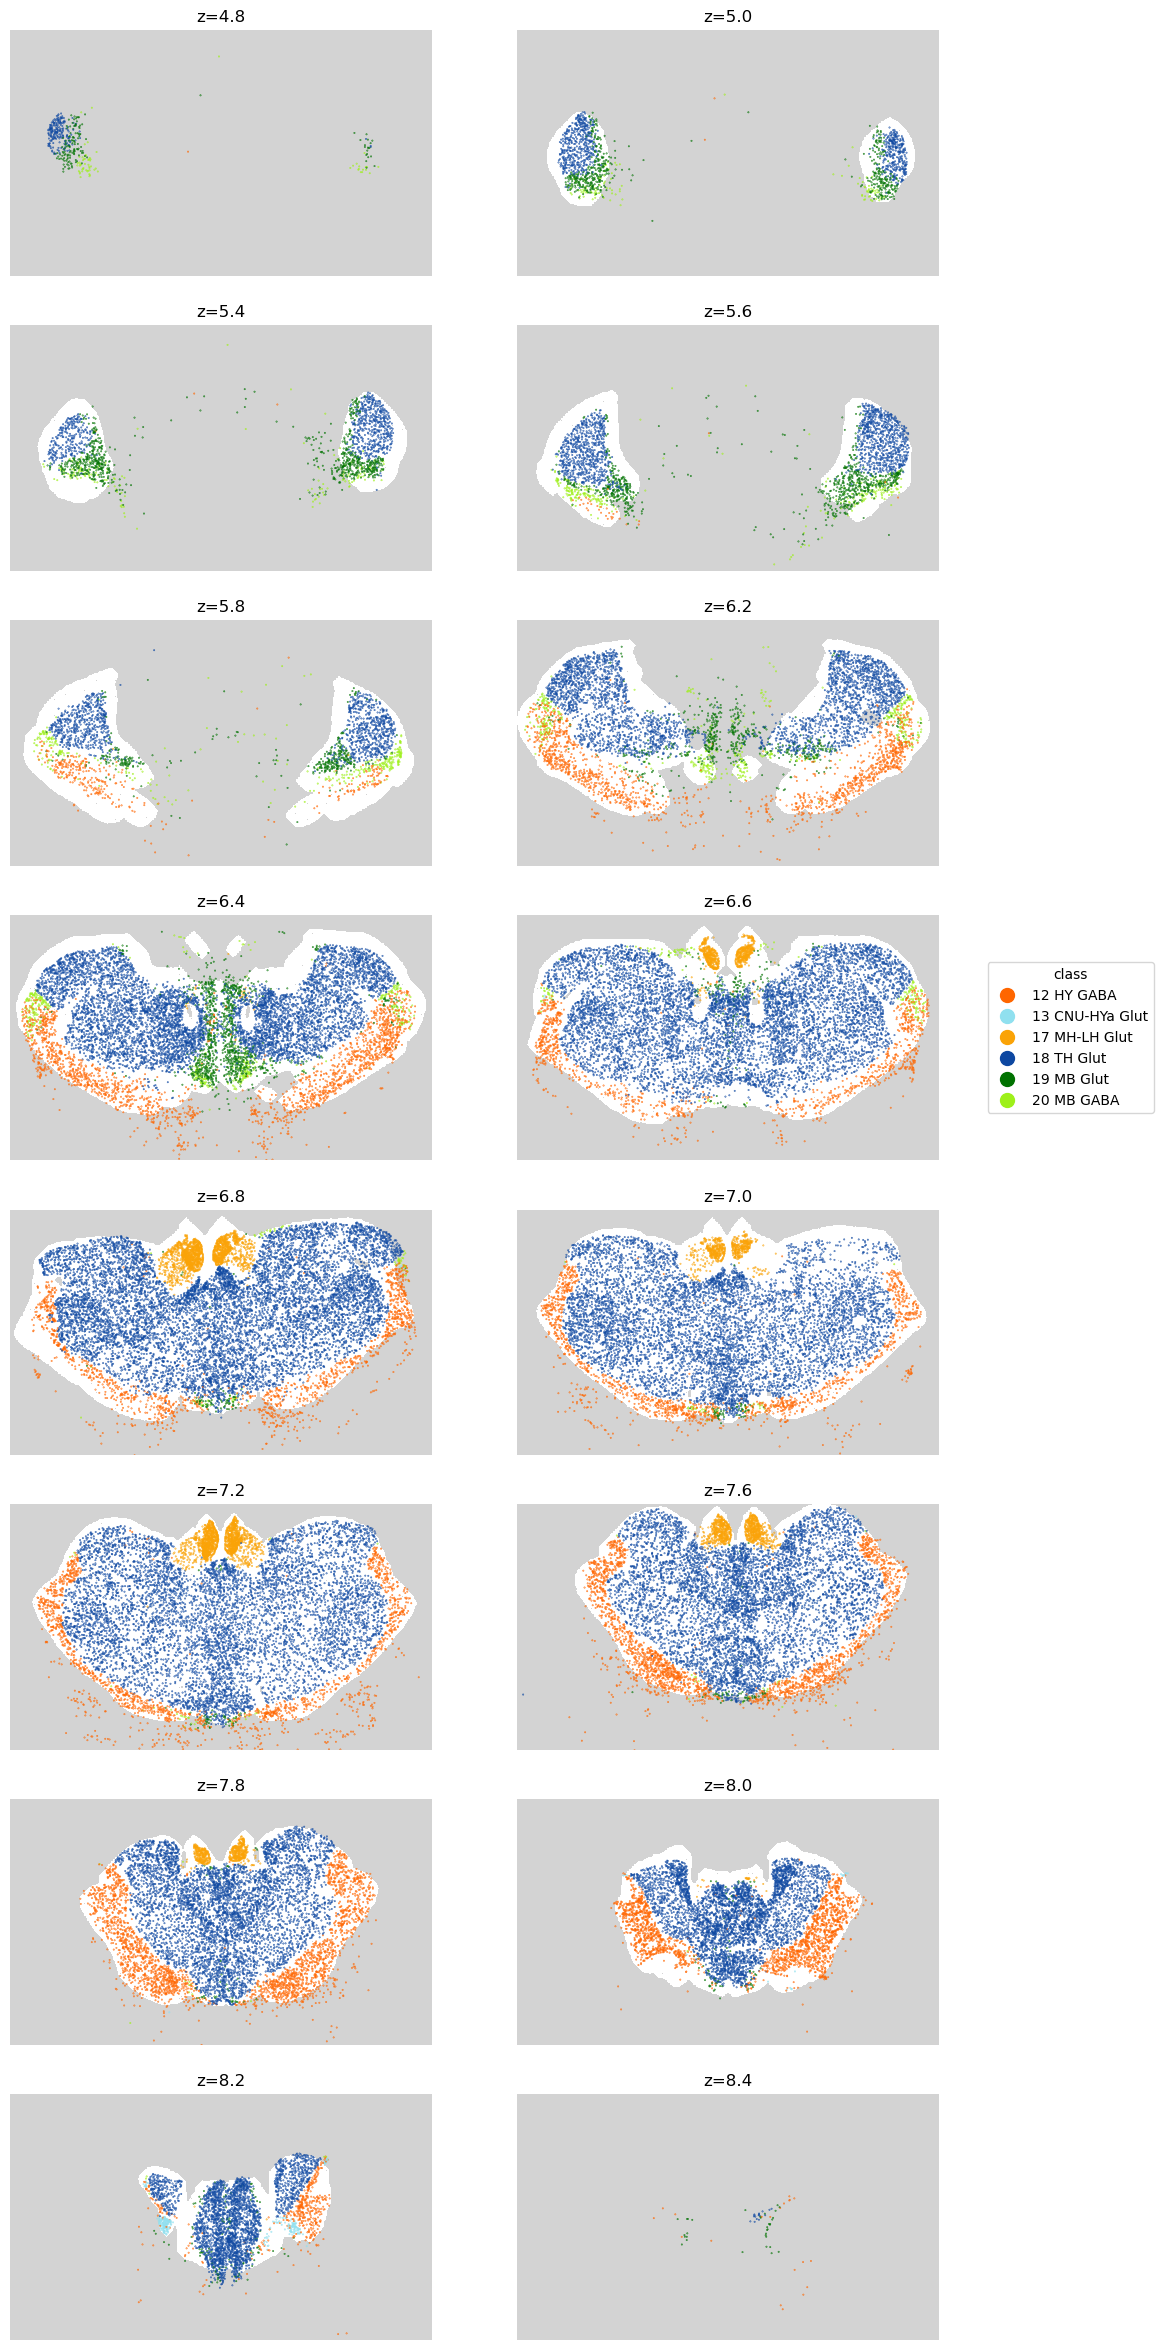

In [60]:
neuronal_th_cells_df = cells_df[(~cells_df['class'].isin(nn_classes))
                                & (cells_df[coords[2]].isin(th_zi_sections))
                                & (cells_df['thal_subclass'])
                               ]  
plot_th_mask_with_cell_overlay(neuronal_th_cells_df, th_mask_dilated, th_zi_sections, column='class')

# For reference, do not rerun

In [32]:
# to break a "run all"
assert False

AssertionError: 

### compare to Brian's outline dataset

In [63]:
# requires old brain 1 dataset to be attached!
_THALAMUS_ANNDATA_PATH = "/data/merfish_638850_AIT17.custom_CCF_annotated_TH_ZI_only_2023-05-04_00-00-00/atlas_brain_638850_AIT17_custom_CCF_annotated_TH_ZI_only.h5ad"
adata_ref = ad.read_h5ad(_THALAMUS_ANNDATA_PATH, backed='r')
old_ids = adata_ref.obs_names.astype('string').intersection(cells_df.index)
# old_ids = abc.get_thalamus_reference_ids().intersection(cells_df.index)
new_ids = cells_df.query(field_name).index

In [64]:

len(old_ids.intersection(new_ids))

164075

In [65]:
len(new_ids.difference(old_ids))

130976

In [66]:
len(old_ids.difference(new_ids))

736